In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.feature.texture import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap


/opt/anaconda3/envs/radiomics_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


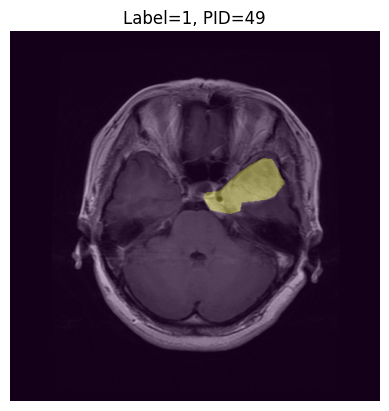

Image shape: (512, 512)
Mask unique values: [0 1]


In [2]:
# Preprocessing

DATASET_ROOT = os.path.expanduser("~/Downloads/dataset")
DATA_DIR = os.path.join(DATASET_ROOT, "data")

def load_mat(file_id):
    path = os.path.join(DATA_DIR, f"{file_id}.mat")

    with h5py.File(path, 'r') as f:    
        cjdata = f['cjdata']

        image = np.array(cjdata['image']).T
        mask = np.array(cjdata['tumorMask']).T
        label = int(np.array(cjdata['label'])[0][0])
        pid = int(np.array(cjdata['PID'])[0][0])

    return image, mask, label, pid

# Normalize Image and visualize
def normalize(img):
    std = np.std(img)
    if std == 0:
        return img
    return (img - np.mean(img)) / np.std(img)

img, mask, label, pid = load_mat(1)
img = normalize(img)

plt.imshow(img, cmap="gray")
plt.imshow(mask, alpha=0.3)
plt.title(f"Label={label}, PID={pid}")
plt.axis("off")
plt.show()

print("Image shape:", img.shape)
print("Mask unique values:", np.unique(mask))


In [3]:
def first_order_features(img, mask):
    region = img[mask > 0]

    return {
        "mean": float(np.mean(region)),
        "std": float(np.std(region)),
        "min": float(np.min(region)),
        "max": float(np.max(region)),
        "skew": float(skew(region)),
        "kurtosis": float(kurtosis(region)),}

def glcm_features(img, mask, distances=[1], angles=[0], levels=64):
    img_norm = (img - img.min()) / (img.max() - img.min() +1e-8)
    img_q = (img_norm * (levels - 1)).astype(np.uint8)

    img_q[mask == 0] = 0
    glcm = graycomatrix(
        img_q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True,)

    features = {}
    for prop in ["contrast", "dissimilarity", "homogeneity", "energy", "correlation"]:
        features[f"glcm_{prop}"] = float(graycoprops(glcm, prop) [0, 0])

    return features

img, mask, label, pid = load_mat(1)
img = normalize(img)

f1 = first_order_features(img, mask)
f2 = glcm_features(img, mask)

print(f1)
print(f2)


{'mean': 1.74278260811534, 'std': 0.5102677149223742, 'min': -0.4577536547072068, 'max': 3.4524903663579694, 'skew': -0.59006606664218, 'kurtosis': 0.9265946090567363}
{'glcm_contrast': 0.39234497309197647, 'glcm_dissimilarity': 0.03051614481409001, 'glcm_homogeneity': 0.9930201950106432, 'glcm_energy': 0.9822444713205136, 'glcm_correlation': 0.9859521698267874}


In [4]:
# Batch extractor
def extract_features_dataset(data_dir):
    rows = []
    mat_files = sorted([
    f for f in os.listdir(data_dir)
    if f.endswith(".mat")])

    for fname in tqdm(mat_files, desc="Extracting features"):
        file_id = fname.replace(".mat", "")
        try:
            img, mask, label, pid = load_mat(file_id)
            img = normalize(img)

            feats = {}
            feats.update(first_order_features(img, mask))
            feats.update(glcm_features(img, mask))

            feats["label"] = label
            feats["pid"] = pid
            feats["file_id"] = file_id

            rows.append(feats)

        except Exception as e:
            print(f"Skipping {fname}: {e}")

    return pd.DataFrame(rows)

df = extract_features_dataset(DATA_DIR)
df.head()

out_path = os.path.join(DATASET_ROOT, "radiomics_features.csv")
df.to_csv(out_path, index=False)

print(f"Saved features to: {out_path}")
print("Shape:", df.shape)
df.columns


Extracting features: 100%|█████████████████| 3064/3064 [00:17<00:00, 177.21it/s]

Saved features to: /Users/varshinisakthi/Downloads/dataset/radiomics_features.csv
Shape: (3064, 14)


Index(['mean', 'std', 'min', 'max', 'skew', 'kurtosis', 'glcm_contrast',
       'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_energy',
       'glcm_correlation', 'label', 'pid', 'file_id'],
      dtype='object')

In [5]:
# ML model training and evaluation
csv_path = "~/Downloads/dataset/radiomics_features.csv"
df = pd.read_csv(csv_path)

print(df.shape)
df.head()
le = LabelEncoder()

X = df[
    [
        "mean", "std", "min", "max", "skew", "kurtosis", 
        "glcm_contrast", "glcm_dissimilarity", "glcm_homogeneity", "glcm_energy",
        "glcm_correlation"]]

y = df["label"]
y_enc = le.fit_transform(y)

print("Original labels:", sorted(y.unique()))
print("Encoded labels: ", sorted(np.unique(y_enc)))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(
    max_iter=500, class_weight = "balanced", random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)

print(y.value_counts())
print("Number of classes:", y.nunique())

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average="macro"))
print("Recall (macro):", recall_score(y_test, y_pred, average="macro"))
print("F1-score (macro):", f1_score(y_test, y_pred, average="macro"))

roc_auc = roc_auc_score(
    y_test, y_prob, average="macro", multi_class="ovr")

print("ROC-AUC (macro, OvR):", roc_auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Random Forest & XGBoost Comparison

rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=5, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, target_names=le.classes_.astype(str)))

xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, objective="multi:softprob", num_class=len(le.classes_),
    eval_metric="mlogloss", random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred, target_names=le.classes_.astype(str)))



(3064, 14)
Original labels: [1, 2, 3]
Encoded labels:  [0, 1, 2]
label
2    1426
3     930
1     708
Name: count, dtype: int64
Number of classes: 3
Accuracy : 0.8433931484502447
Precision (macro): 0.8234610505742682
Recall (macro): 0.8323292708524302
F1-score (macro): 0.8266619606896294
ROC-AUC (macro, OvR): 0.9569061095637665

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       142
           1       0.93      0.89      0.91       285
           2       0.83      0.81      0.82       186

    accuracy                           0.84       613
   macro avg       0.82      0.83      0.83       613
weighted avg       0.85      0.84      0.85       613

Random Forest Accuracy: 0.8629690048939641
              precision    recall  f1-score   support

           1       0.81      0.80      0.80       142
           2       0.91      0.92      0.92       285
           3       0.83      0.82      0.83       186

    a

In [6]:
# Cross-Validation and Hyperparameter Tuning

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

rf_param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 10, 20, 30], 
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    rf, rf_param_grid, n_iter=20, cv=cv, scoring="f1_macro", n_jobs=1,
    verbose=1, random_state=42)

rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
print("Best CV F1-macro:", rf_search.best_score_)

# Evaluate

best_rf = rf_search.best_estimator_
rf_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1-macro:", f1_score(y_test, rf_pred, average="macro"))
print(classification_report(
    y_test, rf_pred, target_names=le.classes_.astype(str)))

importances = pd.Series(
    best_rf.feature_importances_, index=X.columns
).sort_values(ascending=False)

importances.head(10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best CV F1-macro: 0.8554369194269972
Accuracy: 0.866231647634584
F1-macro: 0.8525154214425753
              precision    recall  f1-score   support

           1       0.82      0.80      0.81       142
           2       0.90      0.93      0.92       285
           3       0.84      0.83      0.83       186

    accuracy                           0.87       613
   macro avg       0.86      0.85      0.85       613
weighted avg       0.87      0.87      0.87       613



skew                  0.196172
mean                  0.159240
glcm_correlation      0.132535
min                   0.128378
glcm_energy           0.099099
glcm_homogeneity      0.056258
glcm_contrast         0.054987
std                   0.048522
max                   0.044528
glcm_dissimilarity    0.040882
dtype: float64

In [13]:
# XGBoost Multiclass Model

num_classes = len(np.unique(y_train))

xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, objective="multi:softprob", num_class=num_classes,
    eval_metric="mlogloss", random_state=42, n_jobs=-1)

xgb.fit(X_train, y_train)

xgb_preb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(
    y_test, xgb_pred, target_names=le.classes_.astype(str)))



XGBoost Accuracy: 0.8809135399673735
              precision    recall  f1-score   support

           1       0.85      0.79      0.82       142
           2       0.92      0.93      0.93       285
           3       0.84      0.87      0.85       186

    accuracy                           0.88       613
   macro avg       0.87      0.86      0.87       613
weighted avg       0.88      0.88      0.88       613



PermutationExplainer explainer: 614it [00:42, 10.87it/s]                        
/var/folders/n5/n70ktbxj0kb1k0jzdktwjjth0000gn/T/ipykernel_5575/479045616.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


(613, 11, 3)


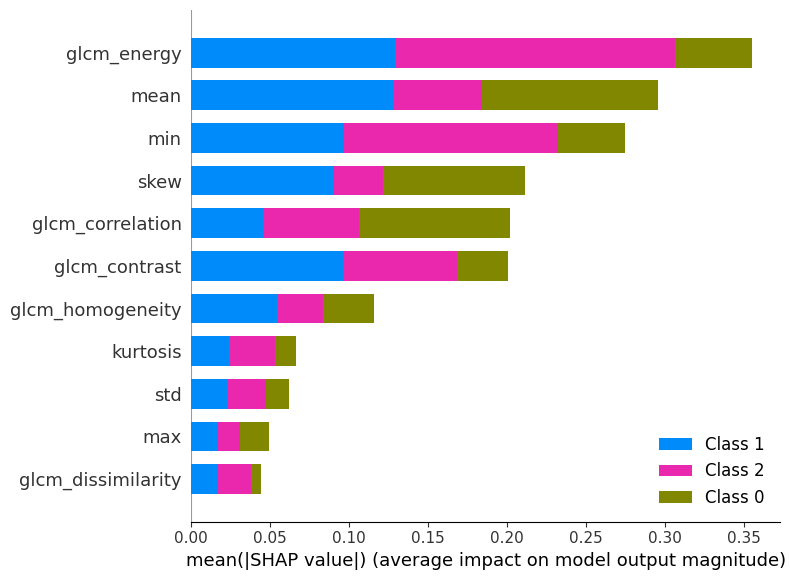

/var/folders/n5/n70ktbxj0kb1k0jzdktwjjth0000gn/T/ipykernel_5575/479045616.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


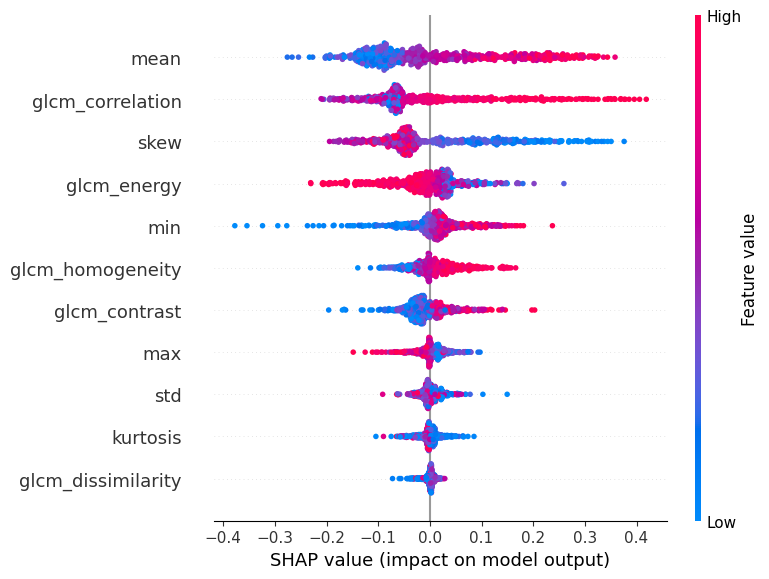

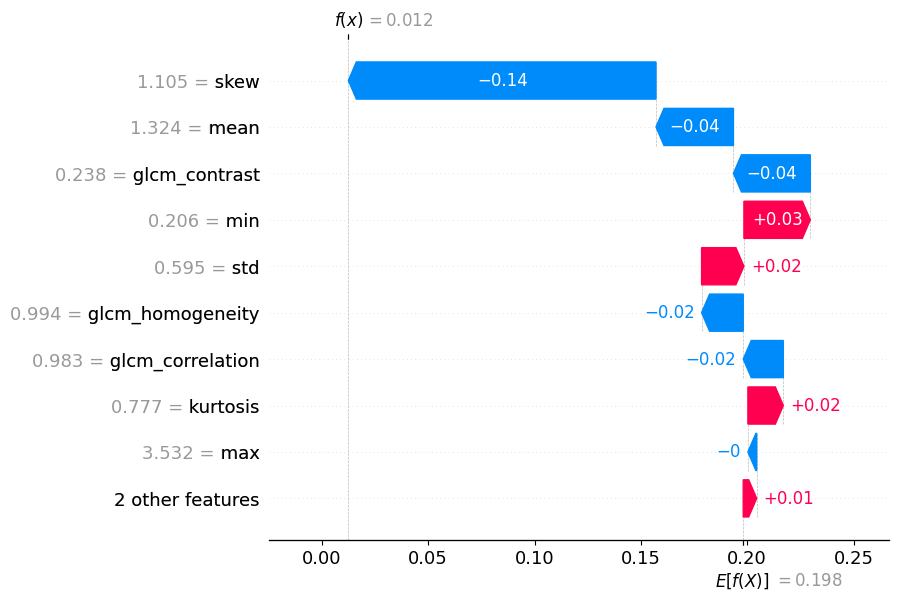

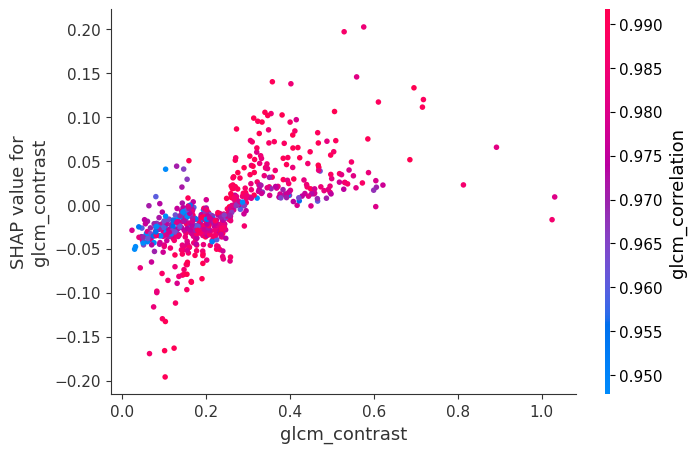

In [30]:
# SHAP Explainer

explainer = shap.Explainer(
    xgb.predict_proba, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)
print(shap_values.shape)

shap.summary_plot(
    shap_values, X_test, plot_type="bar", show=True)

shap_vals = shap_values.values

class_id = 0 # 0, 1, or 2 (tumor classes)
shap.summary_plot(
    shap_values[:, :, class_id], X_test, show=True)

sample_id = 0
shap.plots.waterfall(
    shap.Explanation(
        values=shap_vals[sample_id, :, class_id],
        base_values=shap_values.base_values[sample_id, class_id],
        data=X_test.iloc[sample_id],
        feature_names=X_test.columns),
    show=True)

shap.dependence_plot(
    "glcm_contrast", shap_vals[:, :, class_id], X_test, show=True)

np.save("shap_values.npy", shap_vals)
